In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from quick_downloader import QuickDownloader
from chrome_utils import GrafanaUrlInputs
from processor.load import load_sum_total
from processor.filters import cut_by_window
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from_ts = "2025-08-21 13:36:30"  # Example timestamp
to_ts = "2025-08-21 14:58:30"  # Example timestamp
var_scenario = "ARInvoiceTracker"
resource_groups = "rgQAToolsSaaSAKSResources-EastUS"
names_space = "perflamd1"
vus = 494
l1 = GrafanaUrlInputs(from_ts, to_ts, names_space, "l1", vus, var_scenario, resource_groups)

from_ts = "2025-08-21 18:00:00"  # Example timestamp
to_ts = "2025-08-22 19:15:00"  # Example timestamp
var_scenario = "ARInvoiceTracker"
resource_groups = "rgQAToolsSaaSAKSResources-EastUS"
names_space = "perfwamd2"
w2 = GrafanaUrlInputs(from_ts, to_ts, names_space, "l2", vus, var_scenario, resource_groups)

downloader = QuickDownloader([l1, w2])
data_ = downloader.download()

In [3]:
from typing import Callable


def load_request_per_scenario(path: str, rate_columns: tuple[str, ...] = ("total",)) -> pd.DataFrame:
    df = load_sum_total(path)
    for col in rate_columns:
        df[f"{col}_rate"] = df[col].diff() / df["dT"]
    return df


def get_os_and_processor(name: str) -> tuple[str, str]:
    os = "Windows" if "perfw" in name.lower() else "Linux"
    processor = "AMD" if "amd" in name.lower() else "Intel"
    return os, processor


def merge_dashboards(stored_data: dict[str, dict], dashboard_name: str, loader: Callable[[str], pd.DataFrame]):
    dfs = []
    for data in stored_data.values():
        vus = data["vus"]
        test_instance, identifier = data["instance_identifier"]
        dashboards = data["dashboards"]
        df = loader(dashboards[dashboard_name])
        df["vus"] = vus
        df["instance"] = "{} {}".format(*get_os_and_processor(test_instance))
        df["identifier"] = identifier
        df["os"], df["processor"] = get_os_and_processor(test_instance)
        dfs.append(df)

    merged = pd.concat(dfs)
    merged = merged.sort_index()
    merged = merged.reset_index().set_index("Time")

    return merged

In [4]:
def filter_wrong_totals(df: pd.DataFrame, total_column="total", grouper_column="instance") -> pd.DataFrame:
    result = []
    for _, column_group in df.groupby(grouper_column):
        filtered = column_group[column_group[total_column].diff() >= 0]
        result.append(filtered)
    return pd.concat(result)

In [5]:
def plot_throughput_hist(
        x_col: str,
        df: pd.DataFrame,
        unit: str,
        ylabel: str,
        title: str,
        ax: plt.Axes | None = None
):
    instances = df["instance"].unique()
    palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

    plt.rcParams["text.usetex"] = True

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 2.5))

    sns.histplot(df.reset_index(), x=x_col, hue="instance", kde=True, palette=palette, ax=ax, multiple="layer")

    line_handles = []
    data = {}
    for name, group in df.groupby("instance"):
        mean = group[x_col].mean()
        ax.axvline(mean, color=palette[name], linestyle="-")
        line_handles.append(mlines.Line2D([], [], color=palette[name], linestyle="-", label=rf"$\bar{{x}}$"))
        std = group[x_col].std()

        p25 = np.percentile(group[x_col], 25)
        p75 = np.percentile(group[x_col], 75)
        ax.axvline(p25, color=palette[name], linestyle=":")
        ax.axvline(p75, color=palette[name], linestyle=":")

        line_handles.append(mlines.Line2D([], [], color=palette[name], linestyle=":", label="25th/75th pct"))

        data[name] = {"mean": mean, "std": std}

    hist_handles = [
        mlines.Line2D(
            [], [], color=palette[name], marker='s', linestyle='',
            label=rf"{name} $\bar{{x}}$={data[name]['mean']:0.2f} [{unit}] $\sigma$={data[name]['std']:0.2f} [{unit}]"
        )
        for name in instances
    ]

    hist_handles.extend(line_handles)
    legend1 = ax.legend(handles=hist_handles, title="", loc="upper left")
    ax.add_artist(legend1)

    plt.title(title)
    plt.xlabel(unit)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()

def plot_over_time(df: pd.DataFrame, y_col: str, title: str, ylabel: str, grouper: str = "instance", ax: plt.Axes | None = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 5))
    for name, group in df.groupby(grouper):
        group.plot(use_index=True, y=y_col, label=name, ax=ax)
    plt.title(title)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()

In [6]:
total_requests = merge_dashboards(data_, "Total Requests per Scenario", load_request_per_scenario)
total_iterations = merge_dashboards(data_, "Iterations per Scenario", load_request_per_scenario)

In [7]:
framed = cut_by_window(total_requests, "20m", "40m")
framed = filter_wrong_totals(framed, "total", "instance")
total_iterations = cut_by_window(total_iterations, "20m", "40m")
total_iterations = filter_wrong_totals(total_iterations)

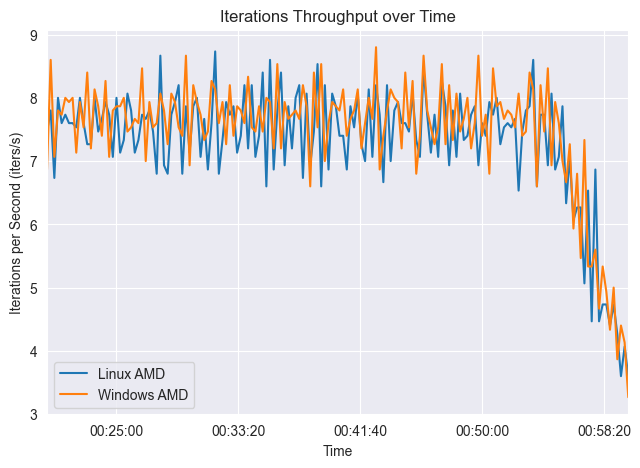

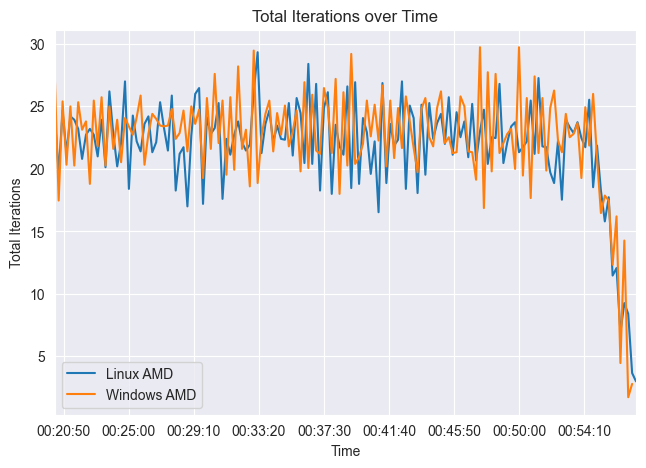

In [9]:
plot_over_time(framed, "total_rate", 'Total Iterations over Time', 'Total Iterations')

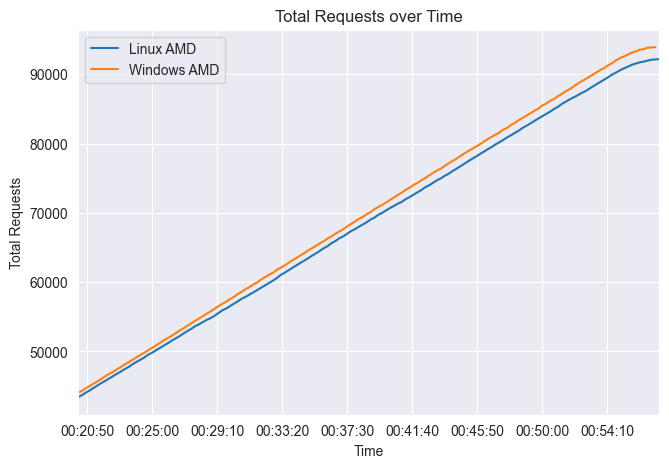

In [10]:
plot_over_time(framed, "total", 'Total Requests over Time', 'Total Requests')

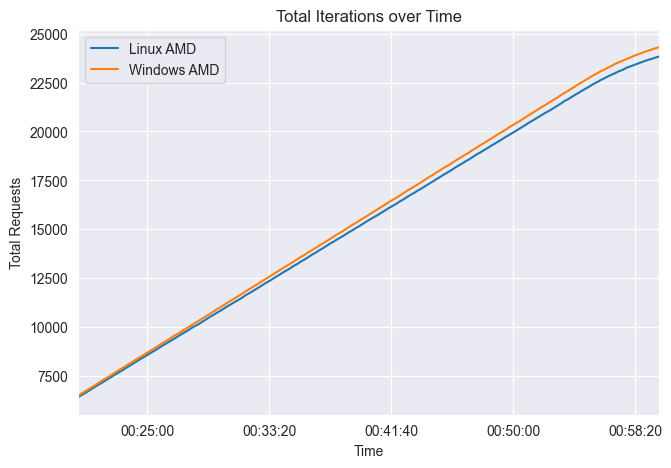

In [11]:
plot_over_time(total_iterations, "total", 'Total Iterations over Time', 'Total Requests')


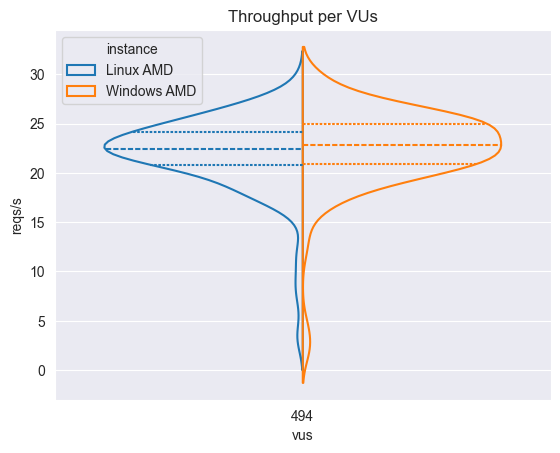

In [12]:
sns.violinplot(framed.reset_index(), x="vus", y="total_rate", hue="instance", split=True, inner='quartile', fill=False)
plt.title("Throughput per VUs")
plt.ylabel("reqs/s")
plt.show()

total_rate                   total                       
                  mean       std          mean           std      max
instance                                                             
Linux AMD    21.859111  4.104275  68667.266667  14712.894828  92192.0
Windows AMD  22.495302  4.134047  69708.597315  14979.495703  93902.0

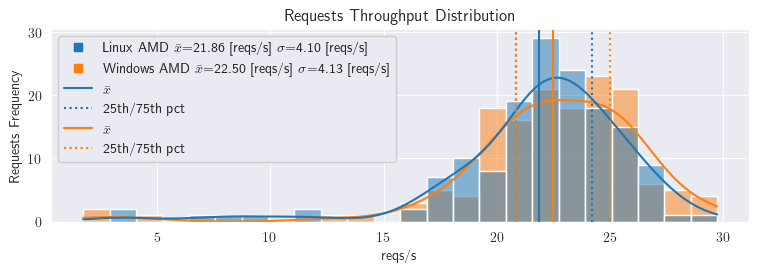

In [22]:
plot_throughput_hist(
    x_col="total_rate",
    df=framed,
    unit=r"{reqs/s}",
    ylabel="Requests Frequency",
    title="Requests Throughput Distribution")
framed.groupby("instance").agg({"total_rate": ['mean', 'std'], "total": ['mean', 'std', "max"]})

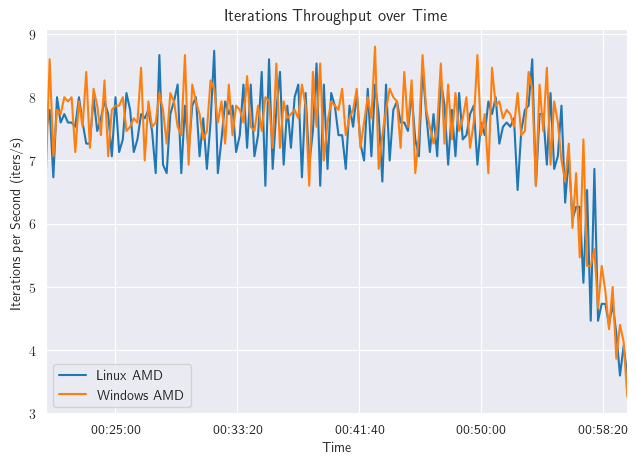

In [24]:
plot_over_time(total_iterations, "total_rate", 'Iterations Throughput over Time', 'Iterations per Second (iters/s)')

total_rate                  total                      
                  mean       std         mean          std      max
instance                                                           
Linux AMD     7.301667  0.960752  15423.57500  5214.770824  23832.0
Windows AMD   7.465833  0.957897  15707.04375  5334.868822  24306.0

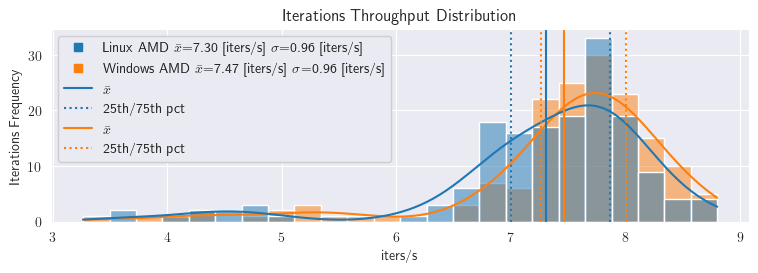

In [25]:
plot_throughput_hist(
    x_col="total_rate",
    df=total_iterations,
    unit=r"{iters/s}",
    ylabel="Iterations Frequency",
    title="Iterations Throughput Distribution")
total_iterations.groupby("instance").agg({"total_rate": ['mean', 'std'], "total": ['mean', 'std', "max"]})

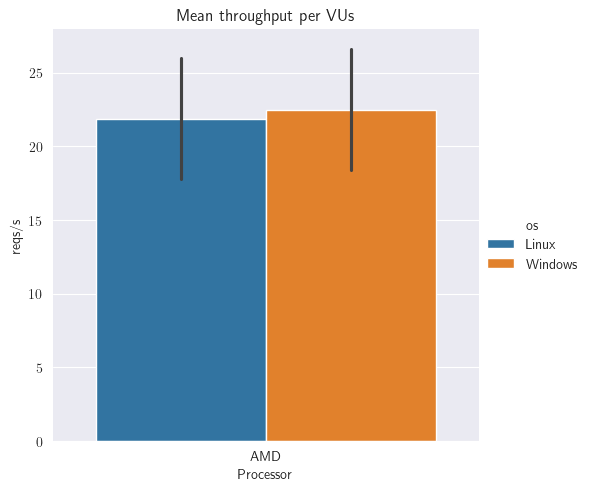

In [15]:
instances = framed["os"].unique()
palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

g = sns.catplot(
    data=framed.reset_index(), kind="bar",
    x="processor", y="total_rate", hue="os", row="vus",
    errorbar="sd", palette=palette
)
g.despine(left=True)
g.set_axis_labels("Processor", "reqs/s")
# g.legend.set_title("Instances throughput")
plt.title("Mean throughput per VUs")
plt.show()

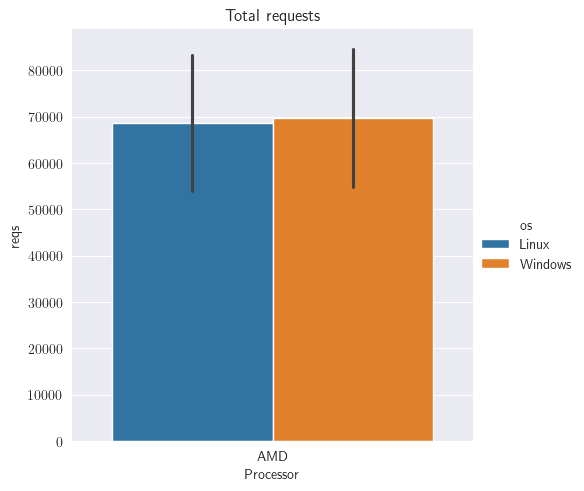

In [16]:
instances = framed["os"].unique()
palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

g = sns.catplot(
    data=framed.reset_index(), kind="bar",
    x="processor", y="total", hue="os", row="vus",
    errorbar="sd", palette=palette
)
g.despine(left=True)
g.set_axis_labels("Processor", "reqs")
# g.legend.set_title("Instances throughput")
plt.title("Total requests")
plt.show()

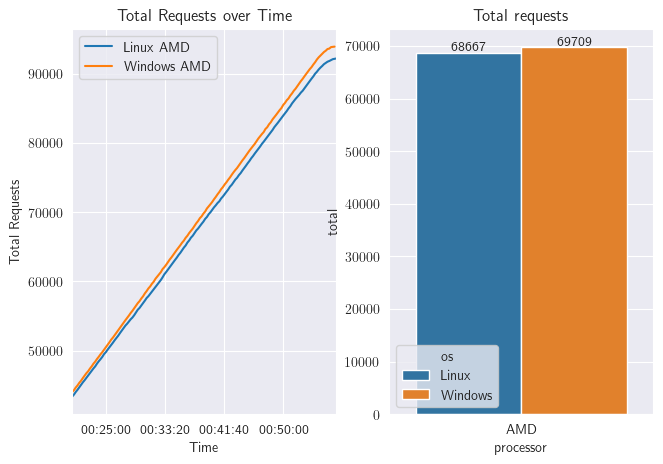

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(7.5, 5))
ax = axs[0]
for name, group in framed.groupby("instance"):
    group.plot(use_index=True, y="total", label=name, ax=ax)

axs[0].set_title('Total Requests over Time')
axs[0].set_ylabel('Total Requests')

instances = framed["os"].unique()
palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

sns.barplot(
    data=framed.reset_index(),
    x="processor", y="total", hue="os",
    ax=axs[1], palette=palette, errorbar=None,  #errorbar="sd",
)
for container in axs[1].containers:
    axs[1].bar_label(container, fmt="%.0f")
axs[1].set_title("Total requests")
# axs[1].set_ylabel("Total Requests")
# g.legend.set_title("Instances throughput")
plt.title("Total requests")

plt.show()

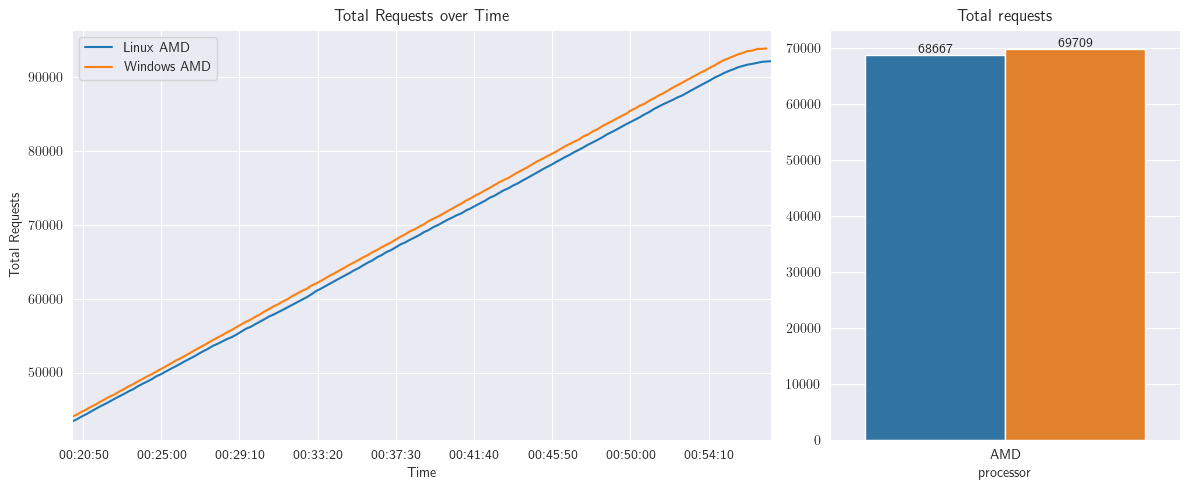

In [18]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3

ax1 = fig.add_subplot(gs[0])
for name, group in framed.groupby("instance"):
    group.plot(use_index=True, y="total", label=name, ax=ax1)
ax1.set_title('Total Requests over Time')
ax1.set_ylabel('Total Requests')

ax2 = fig.add_subplot(gs[1])
instances = framed["os"].unique()
palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))
sns.barplot(
    data=framed.reset_index(),
    x="processor", y="total", hue="os",
    ax=ax2, palette=palette, errorbar=None,
    legend=False
)
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.0f")
ax2.set_title("Total requests")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()